# Notebook for the OpenSky Symposium 2020

Detecting Events in Aircraft Trajectories: Rule-based and Data-driven Approaches  

## Outline

- [Aircraft and callsign based event selection](#Aircraft-and-callsign-based-event-selection)
- [Take-off and Landing](#Take-off-and-Landing)
- [Following a flight plan](#Following-a-flight-plan)
- [Events during final approach](#Events-during-final-approach)
- [Runway changes](#Runway-changes)
- [Holding patterns](#Holding-patterns)

## Aircraft and callsign based event selection

### Firefighting in California

See also:

- https://graphics.reuters.com/CALIFORNIA-WILDFIRE/AIRCRAFT/bdwpkzmyyvm/
- https://planete.lesechos.fr/enquetes/la-cote-pacifique-des-etats-unis-en-proie-aux-flammes-4712/

**Fire location from NASA FIRMS service**

NRT VIIRS 375 m Active Fire product VJ114IMGTDL_NRT.  
Available on-line [https://earthdata.nasa.gov/firms].  

doi: 10.5067/FIRMS/VIIRS/VJ114IMGT_NRT.002


In [1]:
import pandas as pd

# data not provided here for various reasons
calfire_db = pd.read_csv("calfire/calfire.csv")
calfire_db.head()

,icao24,registration,typecode,type,operator
0,a7fc8e,N6132N,UH1,Bell UH-1H,USDA Forest Service FEPP
1,a2f3a1,N29FC,C206,Cessna U206C Stationair,USDA Forest Service FEPP
2,a078ce,N12991,C172,Cessna 172M Skyhawk,USDA Forest Service FEPP
3,a3b588,N338WN,UH1,Bell UH-1H,USDA Forest Service FEPP
4,a3b93f,N339WN,UH1,Bell UH-1H,USDA Forest Service FEPP


In [ ]:
from datetime import timedelta
from traffic.data import opensky

calfire = opensky.history(
    "2020-09-08",
    "2020-09-15",
    icao24=calfire_db.icao24.unique(),
    date_delta=timedelta(hours=6),
)

calfire = (
    calfire.iterate_lazy(
        iterate_kw=dict(by="1H")  # we accept gaps in trajectory for up to 1h
    )
    .query("latitude == latitude")  # remove data with no positional information
    .resample("1s")
    .assign_id()
    .longer_than("2T")
    #  .simplify(5e2)  # simplification applied for the imported version
    .eval(desc="", max_workers=8)
)

In case you have no access to download the data, you can still import the preprocessed version:

In [ ]:
# from traffic.data.samples import calfire

In [ ]:
from traffic.drawing import location
import geopandas as gpd

# download the data from NASA FIRMS service first
gf = gpd.read_file("calfire/fire_nrt_J1V-C2_155605.shp")
west, east, south, north = location("California").extent
fire_locations = gf.query(
    "@west <= LONGITUDE <= @east and @south <= LATITUDE <= @north"
)

In [ ]:
from ipywidgets import Layout
from ipyleaflet import Heatmap


m = calfire.map_leaflet(
    zoom=11, center=(34.2, -118), layout=Layout(max_width="600px", height="600px"),
)
m.add_layer(
    Heatmap(locations=list(zip(fire_locations.LATITUDE, fire_locations.LONGITUDE)))
)
m

A possible way for detecting densities of loops could be to compute a ratio between:
- great circle distance, and
- actually flown curve distance
every interval of 5 minutes.

(See `straight_ratio`)

In [ ]:
def straight_ratio(flight) -> float:
    return flight.distance() / flight.cumulative_distance(False, False).max("cumdist")


calfire_processed = (
    calfire.resample("1s")
    .apply_time("5T", straight_ratio=straight_ratio)
    .eval(desc="", max_workers=8)
)

In [7]:
(
    calfire_processed["AA410_041"] |
    calfire_processed["AA410_041"].query("straight_ratio < .5")
)

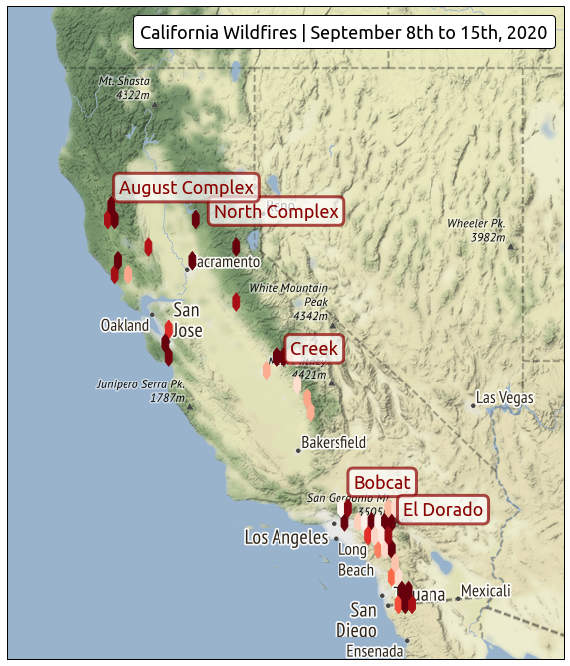

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

from traffic.drawing import PlateCarree, countries
from cartotools.img_tiles import StamenTerrain

cmap = plt.get_cmap("Reds")
cmap.set_under("none")

tiler = StamenTerrain()


with plt.style.context("traffic"):

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection=tiler.crs))
    t_xy = calfire_processed.query("straight_ratio < .5").compute_xy(
        projection=tiler.crs
    )

    ax.hexbin(t_xy.data.x, t_xy.data.y, gridsize=60, cmap=cmap, vmin=400, vmax=2000)
    ax.add_image(tiler, 6)
    ax.set_extent("California", buffer=1)

    for lat, lon, text in [
        (37.1, -119.2, "Creek",),
        (34.7, -117.8, "Bobcat"),
        (34.2, -116.7, "El Dorado"),
        (39.5, -120.9, "North Complex"),
        (39.9, -123, "August Complex"),
    ]:
        ax.text(
            lon,
            lat,
            text,
            transform=PlateCarree(),
            fontname="Ubuntu",
            fontsize=18,
            color="darkred",
            bbox=dict(
                edgecolor="darkred",
                facecolor="white",
                alpha=0.7,
                lw=3,
                boxstyle="round",
            ),
        )

    text = AnchoredText(
        "California Wildfires | September 8th to 15th, 2020",
        loc=1,
        prop={"size": 18, "fontname": "Ubuntu"},
        frameon=True,
    )
    text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(text)

### Ambulance helicopters


In [ ]:
samu = opensky.history(
    "2020-09-10",
    "2020-09-12",
    callsign="SAMU%",
    bounds=location("Occitanie, France"),
    date_delta=timedelta(hours=6),
)

In [ ]:
from traffic.data import airports

m = samu.map_leaflet(zoom=12, layout=Layout(max_width="600px", height="600px"),)

# Hospitals
m.add_layer(airports["FR-0121"])
m.add_layer(airports["FR-0123"])
m.add_layer(airports["LFBO"])

m

### Tour de France (by callsign)

In [ ]:
tour_de_france = opensky.history(
    "2020-08-29",  # Tour de France
    "2020-09-20",
    callsign="(PXR|ASR)[0-9]+",  # regular expression
    date_delta=timedelta(days=1),
)

In [ ]:
# from traffic.data.samples import tour_de_france

In [ ]:
tdf_processed = (
    tour_de_france.iterate_lazy(iterate_kw=dict(by="1H"))
    .assign_id()
    .resample("5s")
    .apply_time("5T", straight_ratio=straight_ratio)
    .query("straight_ratio < .5")
    .max_split()
    .longer_than("1H")
    .eval(desc="", max_workers=8)
)

In [ ]:
tdf_processed.map_leaflet(
    zoom=5, layout=Layout(max_width="600px", height="600px"),
)

<img 
     src="https://img.aso.fr/core_app/img-cycling-tdf-jpg/tdf20-carte-seule-30x40-uk/19147/0:0,820:801-820-0-70/48097"
     alt="Tour de France 2020" style="width: 600px;"/>

## Take-off and Landing

In [ ]:
from traffic.data.datasets import landing_toulouse_2017


def runway_32(flight) -> bool:
    return any(
        segment.max("ILS").startswith("32") for segment in flight.aligned_on_ils("LFBO")
    )


tls32 = (
    landing_toulouse_2017.assign_id()
    .filter()
    .feature_gt("altitude_max", 10000)
    .landing_at("LFBO")
    .filter_if(runway_32)
    .longer_than("2T")
    .eval(desc="", max_workers=8)
)

In [ ]:
from traffic.data import opensky

aircraft_carrier = opensky.history(
    "2020-09-14 21:00", "2020-09-15 01:00", icao24="ae0455", return_flight=True
)

In case you have no access to download the data, you can still import the preprocessed version:

In [ ]:
# from traffic.data.samples import aircraft_carrier

In [ ]:
aircraft_carrier.map_leaflet(
    zoom=8, layout=Layout(max_width="600px", height="600px"),
)

In [19]:
# there are obvious moments when this aircraft does not fly...
resampled = sum(segment.resample("5s") for segment in aircraft_carrier.split())
resampled[aircraft_carrier.icao24].encode("altitude").mark_circle()

alt.Chart(...)

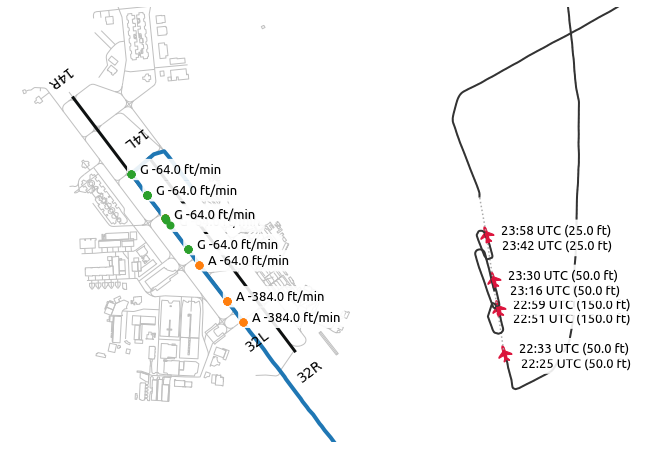

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

from traffic.data import airports
from traffic.drawing import Mercator, PlateCarree, countries

bbox = dict(alpha=0.9, facecolor="white", edgecolor="white", boxstyle="round", zorder=1)

ubuntu13 = dict(fontname="Ubuntu", fontsize=13, bbox=bbox)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(12, 8),
        gridspec_kw=dict(width_ratios=(1.8, 1)),
        subplot_kw=dict(projection=Mercator()),
    )

    tls32["DLH83K_4109"].plot(ax[0], color="C0", lw=4)
    on_runway = next(tls32["DLH83K_4109"].aligned_on_runway("LFBO"))
    on_runway.query("~onground").plot(
        ax[0], linestyle="None", color="C1", marker="o", mec="1.", ms=8, zorder=5
    )
    on_runway.query("onground").plot(
        ax[0], linestyle="None", color="C2", marker="o", mec="1.", ms=8, zorder=5
    )
    airports["LFBO"].plot(ax[0], True, True, labels=dict(fontsize=14))

    ax[0].set_extent(airports["LFBO"].runways)

    for _, x in on_runway.drop_duplicates(["latitude", "longitude"]).data.iterrows():
        ax[0].text(
            x.longitude,
            x.latitude,
            f"   {'G' if x.onground else 'A'} {x.vertical_rate} ft/min",
            transform=PlateCarree(),
            **ubuntu13,
        )

    aircraft_carrier.plot(
        ax[1], color="#aaaaaa", linestyle="dotted",
    )
    for x in aircraft_carrier.split("5T"):
        x.plot(ax[1], color="0.2", lw=2)

    for x in (
        aircraft_carrier.between("2020-09-14 22:00Z", "2020-09-15 00:00Z")
        .query("altitude < 500")
        .split()
    ):
        line, *_ = x.plot(ax[1], color="crimson", lw=3)
        start, stop = x.at_ratio(0), x.at_ratio(1)
        start.plot(
            ax[1],
            zorder=2,
            marker="",
            color=line.get_color(),
            shift=dict(units="dots", y=-8, x=15),
            text_kw=dict(
                s=f"{start.timestamp:%H:%M} UTC ({stop.altitude} ft)", **ubuntu13
            ),
        )
        stop.plot(
            ax[1],
            zorder=2,
            color=line.get_color(),
            text_kw=dict(
                s=f"{stop.timestamp:%H:%M} UTC ({stop.altitude} ft)", **ubuntu13
            ),
        )

    ax[1].set_extent((-118.1, -117.3, 31.1, 32.5))

    ax[0].outline_patch.set_visible(False)
    ax[1].outline_patch.set_visible(False)


## Following a flight plan

In [21]:
from traffic.data.datasets import paris_toulouse_2017
from traffic.data import navaids
import altair as alt

sample_flight = (
    paris_toulouse_2017["AFR43LC_1029"]
    .resample("5s")
    .bearing(navaids["NARAK"], column_name="NARAK")
)

In [22]:
sample_flight.encode(["track", "NARAK"])

alt.Chart(...)

In [ ]:
# Monkey-matching in order to use the next() function

from traffic.core import Flight

Flight.aligned_on_narak = lambda f: f.aligned_on_navpoint([navaids["NARAK"]])
Flight.aligned_on_erixu = lambda f: f.aligned_on_navpoint([navaids["ERIXU"]])
Flight.aligned_on_ertok = lambda f: f.aligned_on_navpoint([navaids["ERTOK"]])
Flight.aligned_on_etamo = lambda f: f.aligned_on_navpoint([navaids["ETAMO"]])
Flight.aligned_on_guere = lambda f: f.aligned_on_navpoint([navaids["GUERE"]])


aligned_on_erixu = (paris_toulouse_2017.next("aligned_on_erixu").eval(
    desc="", max_workers=8
))
aligned_on_ertok = (paris_toulouse_2017.next("aligned_on_ertok").eval(
    desc="", max_workers=8
))
aligned_on_etamo = (paris_toulouse_2017.next("aligned_on_etamo").eval(
    desc="", max_workers=8
))
aligned_on_guere = (paris_toulouse_2017.next("aligned_on_guere").eval(
    desc="", max_workers=8
))
aligned_on_narak = (paris_toulouse_2017.next("aligned_on_narak").eval(
    desc="", max_workers=8
))

In [24]:
(
    (aligned_on_narak - aligned_on_guere - aligned_on_ertok - aligned_on_etamo)
    | (aligned_on_narak & aligned_on_guere & aligned_on_ertok & aligned_on_etamo)
)

,count
flight_id,
EZY4019_3333,2497
AFR43LC_1029,2363
EZY4029_2881,2348
AFR61JJ_985,2334
EZY289N_2912,2247
EZY24EH_3215,2233
AFR65WA_1331,2208
AFR49DL_1632,2193
AFR613R_2065,2191


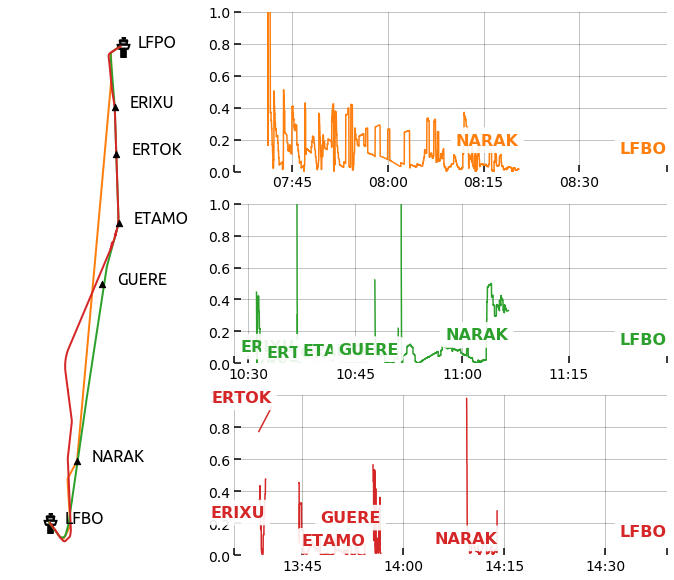

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt

from traffic.drawing import Lambert93, countries
from traffic.core import FlightPlan
from traffic.data import airports

fp = FlightPlan("N0428F330 ERIXU UN860 GUERE UZ365 NARAK")

with plt.style.context("traffic"):

    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 3)

    map_ax = fig.add_subplot(gs[:, 0], projection=Lambert93())
    for p in fp.all_points:
        p.plot(
            map_ax,
            marker="^",
            s=40,
            zorder=5,
            text_kw=dict(fontname="Ubuntu", fontsize=16),
        )

    airports["LFBO"].point.plot(
        map_ax, text_kw=dict(fontname="Ubuntu", fontsize=16),
    )
    airports["LFPO"].point.plot(
        map_ax, text_kw=dict(fontname="Ubuntu", fontsize=16),
    )

    map_ax.set_extent(fp, buffer=1)
    map_ax.outline_patch.set_visible(False)

    ax0 = fig.add_subplot(gs[0, 1:])
    ax1 = fig.add_subplot(gs[1, 1:])
    ax2 = fig.add_subplot(gs[2, 1:])

    steps = [
        "aligned_on_erixu",
        "aligned_on_ertok",
        "aligned_on_etamo",
        "aligned_on_guere",
        "aligned_on_narak",
    ]

    for flight, ax_, color in zip(
        ["AFR43LC_1029", "AFR61UJ_2071", "EZY4029_3237"],
        [ax0, ax1, ax2],
        ["C1", "C2", "C3"],
    ):
        f = paris_toulouse_2017[flight]
        h_, *_ = f.plot(map_ax, color=color, lw=2)
        fmt = dict(
            va="bottom",
            ha="right",
            color=h_.get_color(),
            fontsize=16,
            fontweight="bold",
            bbox=dict(
                alpha=0.9,
                facecolor="white",
                edgecolor="white",
                boxstyle="round",
                zorder=1,
            ),
        )

        for step in steps:
            segment = f.next(step)
            if segment is not None:
                name = step.split("_")[-1].upper()
                segment.assign(
                    timestamp=pd.to_datetime(segment.data.timestamp)
                ).plot_time(ax_, "b_diff", color=h_.get_color())

                ax_.text(segment.stop, segment.b_diff_mean * 1.05, name, **fmt)

        ax_.text(f.stop, 0.1, "LFBO", **fmt)

        # Minor adjustments
        ax_.legend_.set_visible(False)
        ax_.set_ylim((0, 1))
        ax_.set_xlim((f.start, f.stop))
        ax_.tick_params(which="both", direction="in", length=7, width=1.5)
        ax_.grid(alpha=0.5, which="both")
        ax_.set_xlabel("")
        plt.setp(ax_.get_xticklabels(), fontsize=14, rotation=0, ha="center")

## Events during final approach

In [26]:
from traffic.data.datasets import landing_zurich_2019


def many_goaround(flight) -> bool:
    return flight.sum("go_around") > 1


(
    landing_zurich_2019
    .query("not simple")
    .filter_if(many_goaround)
    .eval(desc="", max_workers=8)
)

,count
flight_id,
EWG7ME_1079,3018
SWR287A_10099,2386


In [ ]:
from traffic.data import opensky 
circle_to_land = opensky.history(
    "2017-10-27 18:50 CET",
    "2017-10-27 19:00 CET",
    callsign="AAF288L",
    return_flight=True,
)

In [28]:
from traffic.data import airports

airports["LFPO"].geoencode() + circle_to_land.last("5T").geoencode()

alt.LayerChart(...)

In [ ]:
tls32["GAF612"].last("8T") | landing_zurich_2019["SWR287A_10099"] | circle_to_land

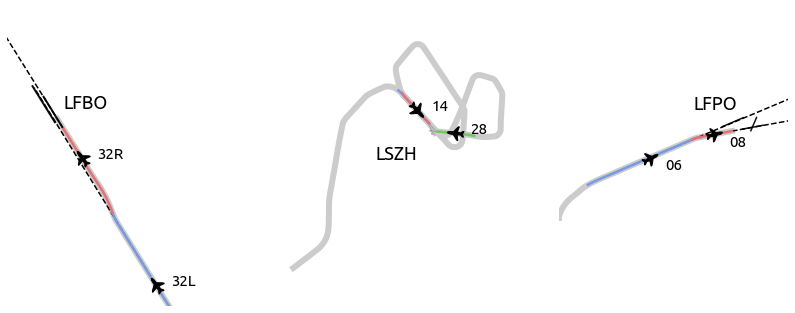

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

from traffic.drawing import EuroPP

with plt.style.context("traffic"):

    fig, ax = plt.subplots(1, 3, figsize=(14, 7), subplot_kw=dict(projection=EuroPP()))

    tls32["GAF612"].last("8T").query("~onground").plot(
        ax[0], lw=6, color="#cccccc", zorder=-2
    )
    airports["LFBO"].plot(ax[0], footprint=False, runways=dict(lw=2))
    airports["LFBO"].point.plot(
        ax[0], s=0, text_kw=dict(fontname="Ubuntu", fontsize=18,)
    )

    for segment in tls32["GAF612"].resample("2s").aligned_on_ils("LFBO"):

        segment.first("4T").comet(minutes=10).plot(ax[0], color="black", ls="--")
        segment.plot(ax[0], lw=2.5)
        segment.at_ratio(0.65).plot(
            ax[0],
            zorder=5,
            text_kw=dict(s=segment.ILS_max, fontname="Ubuntu", fontsize=15,),
        )

    ax[0].set_extent((1.34, 1.54, 43.5, 43.7))

    landing_zurich_2019["SWR287A_10099"].plot(ax[1], lw=6, color="#cccccc", zorder=-2)
    airports["LSZH"].plot(ax[1], runways=dict(lw=0.14))
    airports["LSZH"].point.plot(
        ax[1],
        s=0,
        shift=dict(units="dots", x=-15, y=-15),
        text_kw=dict(fontname="Ubuntu", fontsize=18, ha="right", va="top"),
    )

    for i, segment in enumerate(
        landing_zurich_2019["SWR287A_10099"].resample("2s").aligned_on_ils("LSZH",)
    ):
        segment.plot(ax[1], lw=2.5)
        if i > 0:
            segment.at_ratio(0.5).plot(
                ax[1],
                zorder=5,
                text_kw=dict(s=segment.ILS_max, fontname="Ubuntu", fontsize=15,),
            )

    circle_to_land.last("8T").plot(ax[2], lw=6, color="#cccccc", zorder=-2)
    airports["LFPO"].plot(ax[2], footprint=False, runways=dict(lw=1.5))
    airports["LFPO"].point.plot(
        ax[2],
        s=0,
        shift=dict(units="dots", x=-15, y=15),
        text_kw=dict(fontname="Ubuntu", fontsize=18, ha="right", va="bottom"),
    )
    ax[2].set_extent((2, 2.45, 48.6, 48.75))

    for segment in circle_to_land.resample("2s").aligned_on_ils("LFPO"):
        segment.first("2T").comet(minutes=10).plot(ax[2], color="black", ls="--")
        segment.at_ratio(0.5).plot(
            ax[2],
            zorder=5,
            text_kw=dict(s=segment.ILS_max, fontname="Ubuntu", fontsize=15, va="top"),
        )
        segment.plot(ax[2], lw=2.5)

    for ax_ in ax:
        ax_.outline_patch.set_visible(False)



## Runway changes

In [ ]:
rule_based = tls32.next("runway_change").eval(desc="", max_workers=8)

In [ ]:
from dataclasses import dataclass
from traffic.core.mixins import PointMixin


@dataclass
class Point(PointMixin):
    latitude: float
    longitude: float
    name: str


bo_points = [
    Point(43.465222, 1.536195, "BO410"),
    Point(43.468472, 1.528195, "BO610"),
]
thresholds = [
    Point(43.6185805, 1.3725227, "32L"),
    Point(43.6156582, 1.3802184, "32R"),
]


def final_approach(flight) -> "Optional[Flight]":
    first = next(flight.aligned_on_ils("LFBO"))
    start = flight.before(first.stop).closest_point(bo_points)
    stop = flight.after(first.start).first("30T").closest_point(thresholds)
    segment = flight.between(start.timestamp, stop.timestamp, strict=False)

    if segment is not None and segment.longer_than("2T"):
        return segment.cumulative_distance(reverse=True).query(
            "cumdist < 8"  # nautical miles
        )


tls32_prepared = tls32.iterate_lazy().pipe(final_approach).eval(desc="", max_workers=8)

In [ ]:
from traffic.core import Traffic

import numpy as np
from sklearn.decomposition import PCA

# Prepare a dataset of track angles on final approach
X = np.vstack(
    [
        # for this demonstration we take 50 samples on final approach
        flight.resample(50).data.track
        for flight in tls32_prepared
    ]
)

flight_ids = list(flight.flight_id for flight in tls32_prepared)

pca = PCA()
X_t = pca.fit_transform(X)

second_component = np.abs(X_t[:, 1])
third_component = np.abs(X_t[:, 2])
fourth_component = np.abs(X_t[:, 3])

fpca_based = Traffic.from_flights(
    tls32_prepared[flight_id]
    for flight_id, c2, c3, c4 in zip(
        flight_ids, second_component, third_component, fourth_component
    )
    if c2 > np.percentile(second_component, 90)
    or c3 > np.percentile(third_component, 90)
    or c4 > np.percentile(fourth_component, 90)
)

In [34]:
# where do both methods agree? | what did we miss with FPCA? | what did we miss with rule-based?
(rule_based & fpca_based) | (rule_based - fpca_based) | (fpca_based - rule_based)

,count
flight_id,
GAF612_4393,471
EZY67YN_4909,439
AF130GD_3266,434
AF522VH_2045,353
KLM73N_6101,341
EZY74ZU_5247,339
AF110RL_1660,338
AF130GD_3493,338
AF614ZR_2145,337


In [ ]:
m = rule_based["AF112ZD_2869"].map_leaflet(
    zoom=10,
    highlight=dict(orange=lambda f: next(f.aligned_on_ils("LFBO"))),
    layout=Layout(max_width="600px", height="600px"),
)

for point in bo_points:
    m.add_layer(point)
m.center = point.latlon

m.add_layer(tls32_prepared["AF522VH_2041"], color="red")
m

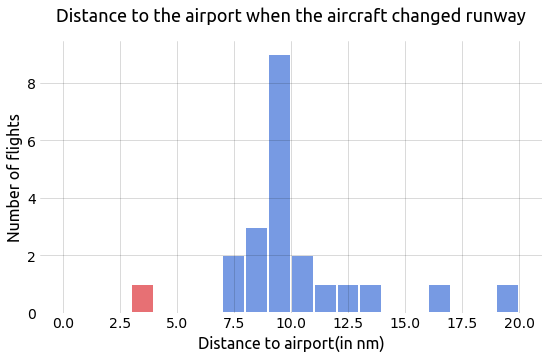

In [36]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(9, 5))
    summary = (
        (rule_based - fpca_based)
        .next("aligned_on_LFBO")
        .distance(airports["LFBO"])
        .eval(desc="", max_workers=8)
        .summary(["flight_id", "distance_min"])
    )
    params = dict(ax=ax, range=(0, 20), bins=20, lw=2, edgecolor="w",)

    summary.query("distance_min > 7").plot.hist(
        "distance_min", facecolor="C0", **params
    )
    summary.query("distance_min < 7").plot.hist(
        "distance_min", facecolor="C1", **params
    )
    ax.legend_.set_visible(False)

    ax.set_xlabel("Distance to airport(in nm)", fontname="Ubuntu")
    ax.set_ylabel("Number of flights", fontname="Ubuntu")

    ax.set_title(
        "Distance to the airport when the aircraft changed runway",
        fontname="Ubuntu",
        fontsize=18,
        pad=20,
    )


In [ ]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(figsize=(9, 5))

    for i, x in enumerate(pca.components_):
        if 0 < i < 4:
            ax.plot(
                np.linspace(0, -8, 50),
                x[::-1],
                label=f"{i+1}th component",
                color=f"C{i}",
                lw=2,
            )

    ax.legend(prop=dict(family="Ubuntu"))
    ax.set_xlabel("Distance to runway threshold (in nm)", fontname="Ubuntu")
    ax.set_title("Variation modes", fontname="Ubuntu", fontsize=18, pad=20)


In [ ]:
flight = tls32["AF134WG_3294"]

m = flight.map_leaflet(
    zoom=11,
    highlight=dict(orange=lambda f: next(f.aligned_on_ils("LFBO"))),
    layout=Layout(max_width="600px", height="600px"),
)

for point in bo_points:
    m.add_layer(point)
m.center = 43.56, 1.44

m

In [ ]:
segment = flight.next("aligned_on_LFBO")

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    airports["LFBO"].plot(ax, runways=True)
    for p in thresholds:
        p.plot(
            ax,
            alpha=0,
            shift=dict(units="dots", x=-10 if p.name == "32L" else 10, y=0),
            text_kw=dict(
                ha="right" if p.name == "32L" else "left",
                fontname="Ubuntu",
                fontsize=14,
            ),
        )
    for p in bo_points:
        p.plot(
            ax,
            marker="^",
            s=40,
            shift=dict(units="dots", x=-10 if p.name == "BO610" else 10, y=0),
            text_kw=dict(
                ha="right" if p.name == "BO610" else "left",
                fontname="Ubuntu",
                fontsize=14,
            ),
        )

    flight.last("10T").before(segment.stop).plot(ax, lw=5, color="0.8")
    segment.plot(ax, color="C1", lw=2, label="ILS 32R")
    ax.set_extent(flight.last("10T"), buffer=0.05)
    ax.outline_patch.set_visible(False)
    ax.legend(prop=dict(family="Ubuntu"))


In [ ]:
with plt.style.context("traffic"):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

    flight.last("10T").before(segment.stop).plot_time(
        ax0, "altitude", color="0.8", lw=5, label=flight.callsign
    )
    segment.plot_time(ax0, "altitude", color="C1", lw=2, label="ILS 32R")

    ax0.set_ylabel("altitude (in ft)", fontname="Ubuntu")
    ax0.legend(prop=dict(family="Ubuntu"))

    flight.last("10T").before(segment.stop).plot_time(
        ax1, "track", color="0.8", lw=5, label=flight.callsign
    )
    segment.plot_time(ax1, "track", color="C1", lw=2, label="ILS 32R")
    ax1.set_ylabel(
        "track angle (in deg)", fontname="Ubuntu",
    )
    ax1.legend(prop=dict(family="Ubuntu"))

    ax1.set_xlabel("")


## Holding patterns

In [ ]:
from traffic.data.datasets import landing_zurich_2019

landing_zurich_2019["UAL52_20691"].sliding_windows("10T", "2T")[:9]

In [ ]:
def rescale_track_per_segment(t_: "Traffic") -> "LazyTraffic":
    return (
        t_.assign(flight_id=lambda df: df.flight_id + "_" + df.index_.astype(str),)
        .iterate_lazy()
        .longer_than("9T")
        .resample(30)
        .assign(x=lambda df: df.track_unwrapped - df.track_unwrapped[0],)
    )


windows = (
    landing_zurich_2019.query("track == track")
    .unwrap()
    .apply_segments(rescale_track_per_segment, "sliding_windows", "10T", "2T")
    .eval(desc="", max_workers=8)
)

In [ ]:
from tqdm.autonotebook import tqdm

total = dict((f.flight_id, f.data.x.values) for f in tqdm(windows))

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

X = np.vstack(list(total.values()))
pca = PCA()
X_t = pca.fit_transform(X)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_)

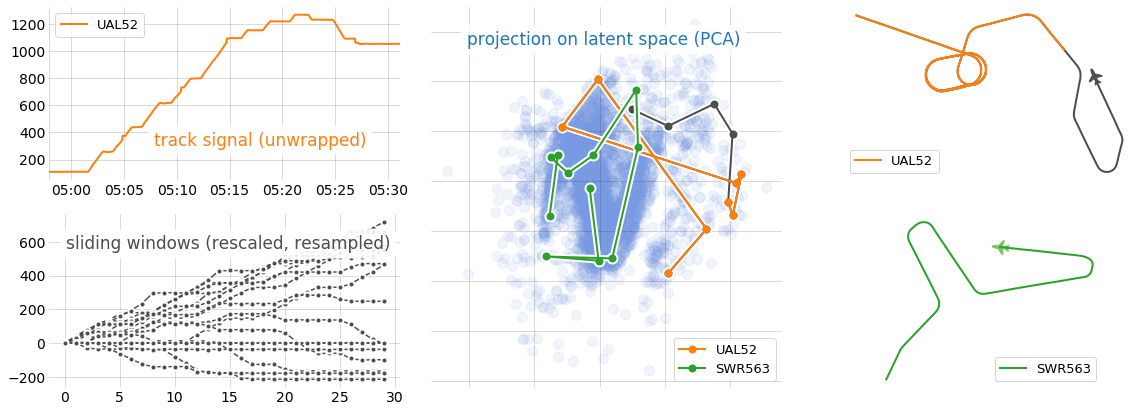

In [46]:
from traffic.core.projection import Mercator

indices = lambda name: list(i for i, x in enumerate(total.keys()) if x.startswith(name))

bbox_dict = lambda ax, color: dict(
    color=color,
    transform=ax.transAxes,
    fontsize=17,
    bbox=dict(alpha=0.9, facecolor="white", edgecolor="white", boxstyle="round",),
)
scatter_white = dict(color="white", lw=6, mec="white", ms=12)
scatter_color = dict(lw=2, ms=8,)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(20, 7))
    gs = fig.add_gridspec(2, 6)

    flight = landing_zurich_2019["UAL52_20691"].unwrap()

    ax = fig.add_subplot(gs[0, :2])
    flight.plot_time(ax, "track_unwrapped", label="UAL52", lw=2, color="C1")
    ax.text(0.3, 0.2, "track signal (unwrapped)", **bbox_dict(ax, "C1"))
    ax.set_xlabel("")
    ax.grid(which="minor")

    ax = fig.add_subplot(gs[1, :2])
    for segment in flight.sliding_windows("10T", "2T"):
        s = segment.assign(
            y=lambda df: df.track_unwrapped - df.track_unwrapped.iloc[0]
        ).resample(30)
        s.data.y.plot(
            ax=ax, color=".3",
        )
        s.data.y.plot(ax=ax, color="white", lw=0, marker="o", markersize=8)
        s.data.y.plot(ax=ax, color=".3", lw=0, marker="o", markersize=4)

    ax.text(0.05, 0.8, "sliding windows (rescaled, resampled)", **bbox_dict(ax, ".3"))

    ax = fig.add_subplot(gs[:, 2:4])
    from sklearn.neighbors import KernelDensity

    k = KernelDensity().fit(X_t)
    xs = k.sample(5000)
    ax.scatter(*xs[:, :2].T, alpha=0.1, color="C0")
    ax.plot(*X_t[indices(flight.flight_id), :2,].T, "o-", **scatter_white)
    ax.plot(*X_t[indices(flight.flight_id), :2,].T, "o-", color=".3", **scatter_color)
    ax.plot(
        *X_t[indices(flight.flight_id)[:8], :2,].T,
        "o-",
        color="C1",
        label=flight.callsign,
        **scatter_color
    )

    flight_2 = landing_zurich_2019["SWR563_6160"]
    ax.plot(*X_t[indices(flight_2.flight_id), :2,].T, "o-", **scatter_white)
    ax.plot(
        *X_t[indices(flight_2.flight_id), :2,].T,
        "o-",
        color="C2",
        label=flight_2.callsign,
        **scatter_color
    )

    ax.set_xticklabels("")
    ax.set_yticklabels("")
    ax.text(0.1, 0.9, "projection on latent space (PCA)", **bbox_dict(ax, "C0"))
    ax.legend(loc="lower right")

    ax = fig.add_subplot(gs[:1, 4:], projection=Mercator())
    flight.plot(ax, color=".3", lw=2)
    flight.sliding_windows("10T", "2T")[:7].all().resample("1s").plot(
        ax, color="C1", label="UAL52", lw=2
    )
    flight.at().plot(ax, color=".3", text_kw=dict(s=""))

    ax.legend()
    ax.outline_patch.set_visible(False)

    ax = fig.add_subplot(gs[1:, 4:], projection=Mercator())
    flight_2.plot(ax, color="C2", lw=2, label="SWR563")
    flight_2.at().plot(ax, color="C2", text_kw=dict(s=""))
    ax.legend(loc="lower right")
    ax.outline_patch.set_visible(False)

In [ ]:
from traffic.data.samples.surveys import ign_lot_et_garonne
from traffic.data.samples.military import inflight_refuelling
from traffic.data.samples.firefighting import calfire

from traffic.data.datasets import landing_zurich_2019

flights = [
    ign_lot_et_garonne,  
    inflight_refuelling.skip("25T").first("110T"),
    calfire["AA410_040"].skip("1H").first("2H"),
    landing_zurich_2019["KLM57C_4601"].skip("2T").first("10T"),
    landing_zurich_2019["YUPMK_19065"].skip("2T").first("10T"),
    landing_zurich_2019["UAL52_20691"].skip("2T").first("20T").resample('1s')

]

from functools import reduce
from operator import or_

reduce(or_, flights)



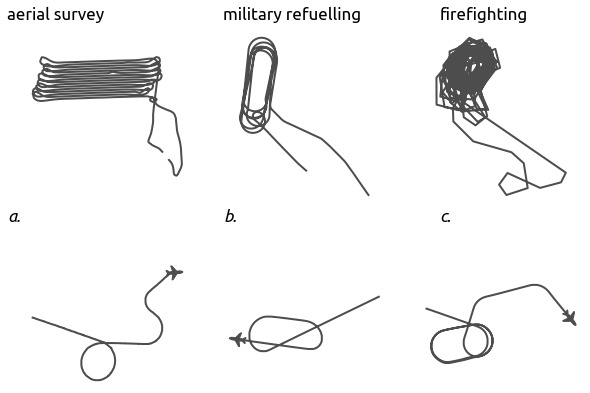

In [48]:
from traffic.core.projection import Mercator

titles = ["aerial survey", "military refuelling", "firefighting", "a.", "b.", "c."]

with plt.style.context("traffic"):
    fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=Mercator()))

    for ax_, flight, title, i in zip(ax.ravel(), flights, titles, range(6)):
        flight.plot(ax_, lw=2, color="0.3")
        if i > 2:
            flight.at().plot(ax_, color="0.3", text_kw=dict(s=""))
        # ax_.set_title(title, fontdict=dict(name="Ubuntu", size=17), loc="left", y=0.95)
        ax_.outline_patch.set_visible(False)

        ax_.text(
            0.1 + 0.3 * (i % 3),
            0.9 if i < 3 else 0.5,
            title,
            transform=fig.transFigure,
            fontname="Ubuntu",
            fontsize=17,
            fontstyle="italic" if i > 2 else "normal",
        )
